# Neural Style Transfer

NST is a deep learning technique where it merge a "content" image with a "style" image. The new image combines both the content of the first image and the style of the second image.

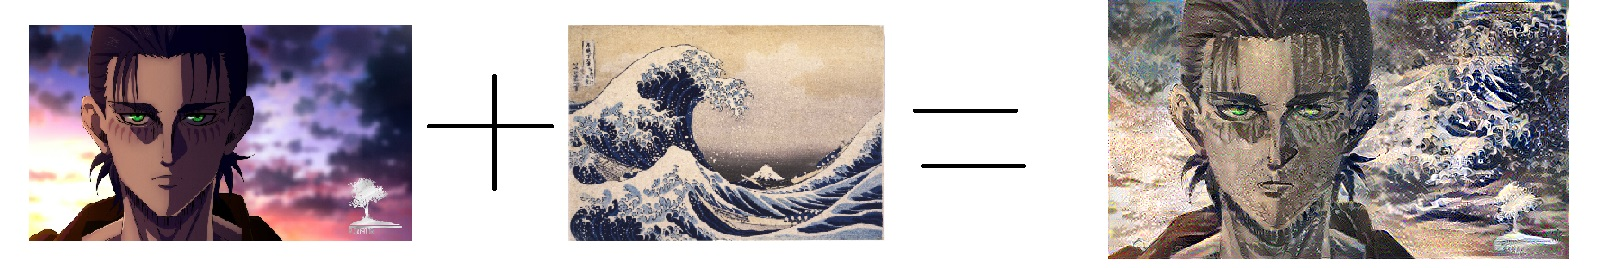

# Library

In [15]:
import os
import tensorflow as tf

import matplotlib.pyplot as plt

import numpy as np
import PIL.Image

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
def load_img(path):
    img_size = 512
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = img_size / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)

    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [18]:
content_path = 'drive/MyDrive/eren.jpg'
style_path = 'drive/MyDrive/art.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

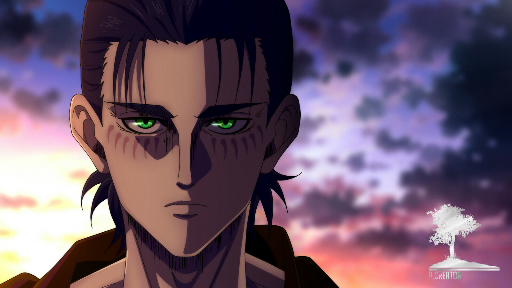

In [19]:
tensor_to_image(content_image)

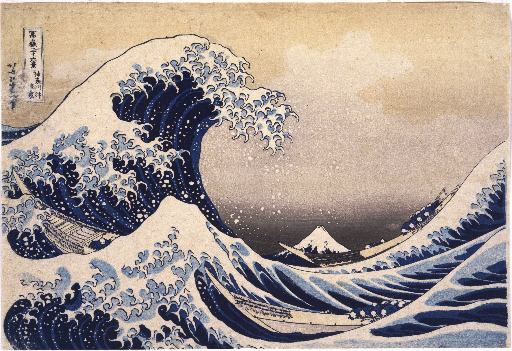

In [20]:
tensor_to_image(style_image)

# Transfer Learning

NST can use any pre-trained CNN model. Here VGG19 is chosen. 
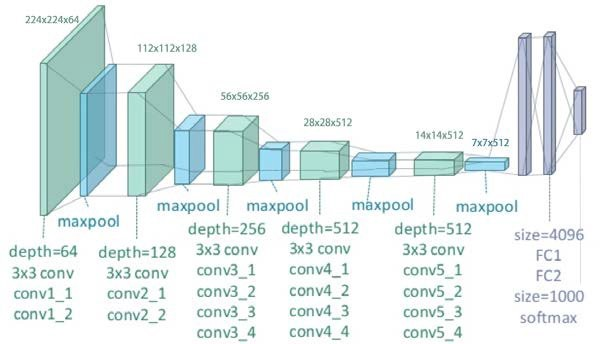

Any VGG19 layer represent a picture as a feature map and we can extract that representation from the output of a layer. 

We create a Functional API model. This kind of model is different from Sequential API in a way that we can extract output of any layer as well as have as many outputs or inputs as we want. Here we use it to extract the content and the style of a picture.

In [21]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

content_layers_output = [vgg.get_layer(name).output for name in content_layers]
style_layers_output = [vgg.get_layer(name).output for name in style_layers]

model = tf.keras.Model([vgg.input], content_layers_output + style_layers_output)

In [22]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

def forward(image, type_output):
    image = image*255.0
    preprocessed_image = tf.keras.applications.vgg19.preprocess_input(image)
    
    results = model(preprocessed_image)
    content_result = results[0:1]
    
    style_result = results[1:]
    style_result = [gram_matrix(style_matrix)
                    for style_matrix in style_result]
    
    if type_output == 'content':
        return content_result
    if type_output == 'style':
        return style_result
    return content_result, style_result

Forward the content image and the style image into the model to get their content and style representation. We will use these representation to optimize the new image.

In [23]:
content_outputs = forward(content_image, 'content')
style_outputs = forward(style_image, 'style')

In [24]:
generated_image = tf.Variable(content_image)
style_weight = 1e-3
content_weight = 1e4

# Cost function

* Content cost function between the content output of the original picture and the new picture
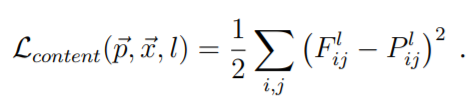


* Style cost betwwen the style output of the style picture and new picture function requires the computation of the gram matrix

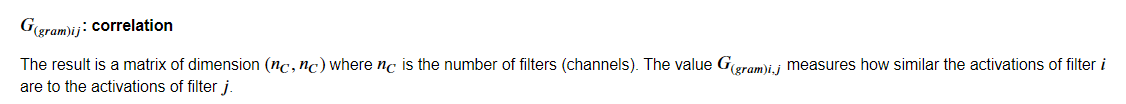

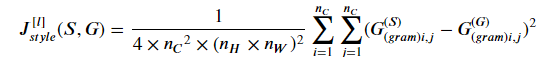

* total loss = weight of content loss * content loss + weight of style loss * style loss


In [25]:
def clip(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def calculate_loss(generated_content, generated_style):
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[0]-generated_content[0])**2)])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[i]-generated_style[i])**2)
                          for i in range(5)])
    loss = content_weight*content_loss + style_weight*style_loss
    return loss

* Create a new generated image that is the content image. Forward it into the model and optimize its value so that we have the minimum total loss

In [26]:
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        generated_content, generated_style = forward(generated_image, 'both')
        loss = calculate_loss(generated_content, generated_style)
    
    grad = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip(generated_image))

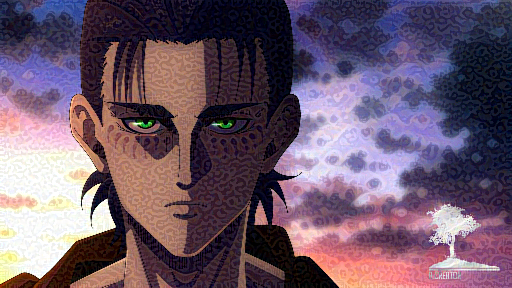

In [27]:
train_step(generated_image)
train_step(generated_image)
train_step(generated_image)
tensor_to_image(generated_image)

Epochs: 100


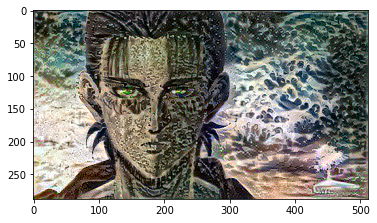

Epochs: 200


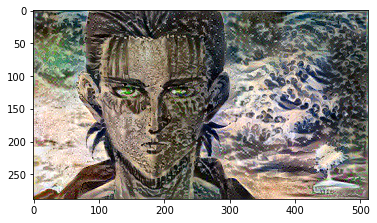

Epochs: 300


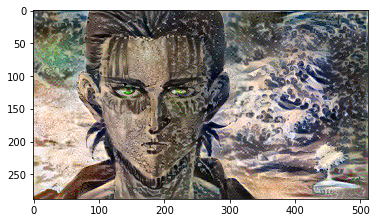

Epochs: 400


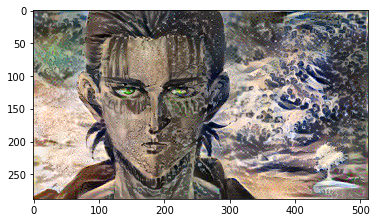

Epochs: 500


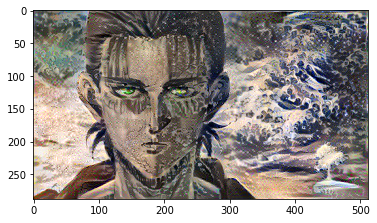

Epochs: 600


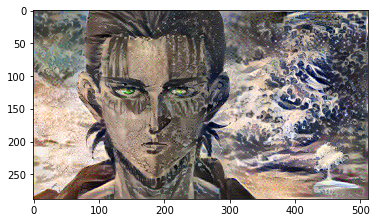

Epochs: 700


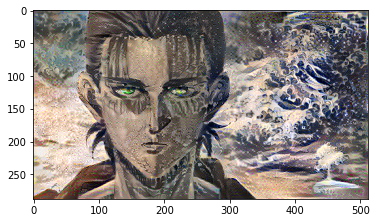

Epochs: 800


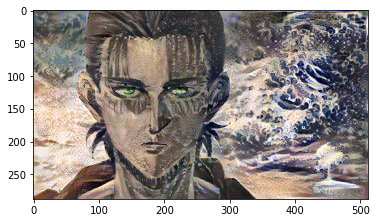

Epochs: 900


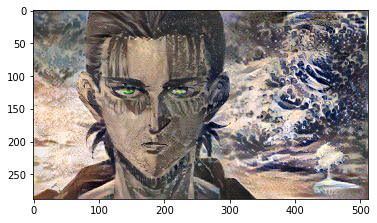

Epochs: 1000


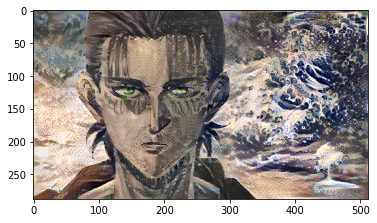

In [28]:
epochs = 1000
for i in range(epochs):
    train_step(generated_image)
    if i % 100 == 99:
        print('Epochs: ' + str(i+1))
        temp = tensor_to_image(generated_image)
        plt.imshow(temp)
        plt.show()

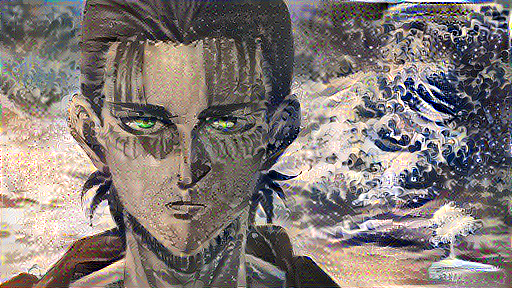

In [29]:
tensor_to_image(generated_image)